# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import struct
import time
from decimal import Decimal
import chipwhisperer as cw
import os

# Get weight values

In [2]:
total_num_of_weight = 401
def get_weights_arr():
    weights_arr = []
    w_val = Decimal('-2.0')
    step = Decimal('0.01')
    for i in range (total_num_of_weight):
        weights_arr.append(float(w_val))
        w_val += step
    return weights_arr

weights_arr = get_weights_arr()
#the weight value to be recovered
true_weight = -0.21
true_weight_index = weights_arr.index(true_weight)
print(true_weight_index)

179


# Function Definitions

In [3]:
def float_to_binary_str(f):
    # Pack the float into 4 bytes (32-bit) using IEEE 754 standard
    [packed] = struct.unpack('!I', struct.pack('!f', f))
    # Convert the packed number to a binary string
    return f"{packed:032b}"

In [4]:
def HW_float32(f):
    # Get the binary representation of the 32-bit float
    binary_str = float_to_binary_str(f)
    # Count and return the number of '1' bits
    return binary_str.count('1')

In [5]:
#get one part of the binary representation
def getbyte(f,byte_position):
    if byte_position == 0:#sign bit
        inbinary = float_to_binary_str(f)[0]
    elif byte_position == 4:#last 7 bits
        inbinary = float_to_binary_str(f)[25:32]
    else:
        inbinary = float_to_binary_str(f)[(byte_position-1)*8+1:byte_position*8+1]
    
    return int(inbinary,2)

#### The values to be recovered

In [6]:
#true values of different parts of the weight
true_sign_bit = getbyte(true_weight,0)
true_exponent_bits = getbyte(true_weight,1)
true_byte_two = getbyte(true_weight,2)
true_byte_three = getbyte(true_weight,3)
true_byte_four = getbyte(true_weight,4)
true_value_index = weights_arr.index(true_weight)

In [7]:
print("sign bit = " + str(true_sign_bit) + ", exponent = " + str(true_exponent_bits) + ", first mantissa byte = " + str(true_byte_two) + ", second mantissa byte = " + str(true_byte_three) + ", last 7 bits = " + str(true_byte_four))

sign bit = 1, exponent = 124, first mantissa byte = 174, second mantissa byte = 20, last 7 bits = 61


In [8]:
def get_hypothetical_leakages(num_of_traces, inputs_arr):
    hypothetical_leakages = [[] for i in range(total_num_of_weight)]
    for weight_index in range(total_num_of_weight):
        for j in range(num_of_traces):
            #compute the hypothetical product values for each hypothetical value of weight and each random input
            hypothetical_product = weights_arr[weight_index] * inputs_arr[j]
            #compute hypothetical leakages
            hypothetical_leakages[weight_index].append(HW_float32(hypothetical_product))
    return np.array(hypothetical_leakages)

In [9]:
def CPA_attack(num_of_traces, inputs_arr, total_time_sample, start_time_sample, trace_arr):
    r_abs = [[] for i in range(total_num_of_weight)]
    #get hypothetical leakages
    hypothetical_leakages = get_hypothetical_leakages(num_of_traces, inputs_arr)
    for t in range(total_time_sample):
        time_sample_index = t + start_time_sample
        if t%100 == 0:
            print(f'num_of_traces={num_of_traces} ({start_time_sample}-{start_time_sample + total_time_sample}) time samples - calculating for time sample {str(time_sample_index)}')
        for weight_index in range(total_num_of_weight):
            corr_coef = np.corrcoef(hypothetical_leakages[weight_index][:num_of_traces],trace_arr[:num_of_traces,time_sample_index])[0][1]
            r_abs[weight_index].append(abs(corr_coef))
    return r_abs  

In [10]:
def recover_byte(correlation_arr, byte_position, total_time_sample):
    num_of_different_values = 256 #for byte two and three and exponent bits, we have 256 different values
    if byte_position == 0:#for sign bit, there are just 2 different values
        num_of_different_values = 2
    if byte_position == 4:#for last 7 bits, there are 2^7 different values
        num_of_different_values = 128
    correlations = [[0 for t in range(total_time_sample)] for i in range(num_of_different_values)]
    for weight_index in range(total_num_of_weight):#for each weight
        byte_value = getbyte(weights_arr[weight_index],byte_position)#for the chosen byte of this weight value
        for t in range(total_time_sample):#take the correlations for this weight value, for each time sample, update the correlations
            if correlation_arr[weight_index][t] > correlations[byte_value][t]:
                correlations[byte_value][t] = correlation_arr[weight_index][t]
        
    return correlations

In [11]:
def plot_correlations(correlation, value_index, total_time_sample, start_time_sample, save=False, fig_name="test.svg", fig_folder="./"):
    x = []
    total_plots = len(correlation)
    
    for t in range(total_time_sample):
        x.append(t+start_time_sample)
    
    plt.plot(x,correlation[value_index], color="r")
    
    for i in range(total_plots):
        if i == value_index:
            continue
        else: 
            plt.plot(x,correlation[i], color="#808080")
    if save:
        plt.savefig(fig_folder + fig_name, format='svg')
    return

In [12]:
def savefile(foldername, filename, arr, total_time_sample, start_time_sample):
    if not os.path.exists(foldername):
        os.makedirs(foldername)
        
    f = open(foldername + "//" + filename + ".txt", "w")
    length = len(arr)#number of columns
    
    
    #first line
    f.write("x ")
    for i in range(length):
        f.write("y"+str(i)+" ")
    f.write("\n")
    
    for t in range(total_time_sample):#for each line
        f.write(str(t+start_time_sample)+" ")#first write down the time sample
        for j in range(length):
            f.write(str(arr[j][t])+" ")
        f.write("\n")
    f.close()
    return

In [13]:
def load_file(foldername, filename):
    f = open(foldername + "//" + filename + ".txt", "r")
    first_line = f.realine()
    a = first_line.split(" ")
    print(a)
    print(len(a))
    
    

In [14]:
def load_traces(num_of_traces, folder_name):
    trace_waves_arr = []
    inputs_arr = []

    for i in range(num_of_traces):
        with open(folder_name + '/trace_'+str(i)+'.txt') as f:
            lines = f.read().splitlines()
            trace_waves_arr.append(lines)

    with open(folder_name + '/inputs.txt') as f:
        inputs_arr = f.read().splitlines()
    trace_waves_arr = np.array(trace_waves_arr)
    trace_waves_arr = trace_waves_arr.astype(float)

    inputs_arr = np.array(inputs_arr[:num_of_traces])
    inputs_arr = inputs_arr.astype(float)
    return trace_waves_arr, inputs_arr

In [15]:
def load_traces_cw_project(project_folder, project_name):
    proj = cw.open_project(project_folder + project_name)
    trace_waves_arr = []
    inputs_arr = []

    for trace in proj.traces:
        trace_waves_arr.append(trace.wave)
        inputs_arr.append(trace.textin)
        
    trace_waves_arr = np.array(trace_waves_arr)
    trace_waves_arr = trace_waves_arr.astype(float)
    
    inputs_arr = np.array(inputs_arr)
    inputs_arr = inputs_arr.astype(float)
    proj.close()
    return trace_waves_arr, inputs_arr

In [16]:
#### Find the maximum values for correlations for first byte of mantissa
def find_max_first_byte(total_time_sample, start_time_sample, foldername, filename, cor):
    max_values = [0 for t in range(total_time_sample)]
    for t in range(total_time_sample):
        for ex in range(256):
            if ex == true_byte_two:
                continue
            else:
                if(cor[ex][t] > max_values[t]):
                    max_values[t]= cor[ex][t]
                
    #save the file
    f = open(foldername + "//" + filename + ".txt", "w")    
    
    #first line---
    f.write("x y\n")
    #other lines
    for t in range(total_time_sample):#for each line
        f.write(str(t+start_time_sample)+" " + str(max_values[t])+"\n")#first write down the time sample, then the correlation value
    f.close()
    return

In [17]:
def find_max_and_max_true(correlation_arr, true_value_index):
    overall_max = 0
    true_max = 0
    total_plots = len(correlation_arr)
    
    for i in range(total_plots):
        if i == true_value_index:
            true_max = max(correlation_arr[i])
        else:
            w_max = max(correlation_arr[i])
            if w_max > overall_max:
                overall_max = w_max
                
    return overall_max, true_max

# Attack on unprotected traces

In [18]:
project_name = "fourth_weight_unprotected"
save_figures = True

In [19]:
#traces, inputs = load_traces(num_of_traces=10000, folder_name="txt_traces/project-unprotected-10k-decimate1")
traces, inputs = load_traces_cw_project(project_folder="cw_projects/", project_name= project_name)

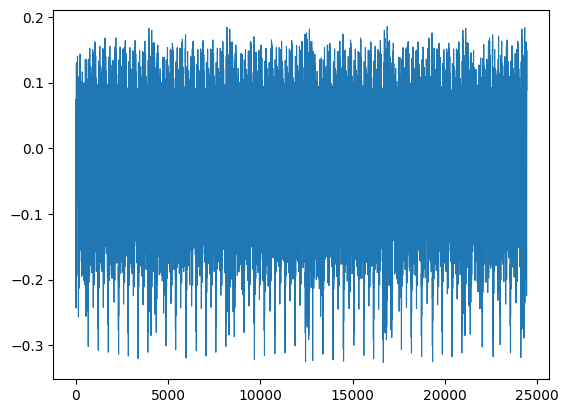

In [20]:
# Added this to verify what the trace looks like
def plot_trace(trace, vlines=[], save=False, fig_name='figure.svg'):
    # Plot the trace
    plt.plot(trace, linewidth=0.8)
    if len(vlines) > 0:
        plt.vlines(vlines, -0.3, 0.2, colors='red')
    if save:
        plt.savefig(fig_name, format='svg')
    plt.show()
    
plot_trace(traces[0])

In [21]:
start = 2080 #1011
end = 2620 #1550
total = end - start

In [22]:
r = CPA_attack(num_of_traces=10000, inputs_arr=inputs, total_time_sample=total, start_time_sample=start, trace_arr=traces)

num_of_traces=10000 (2080-2620) time samples - calculating for time sample 2080
num_of_traces=10000 (2080-2620) time samples - calculating for time sample 2180
num_of_traces=10000 (2080-2620) time samples - calculating for time sample 2280
num_of_traces=10000 (2080-2620) time samples - calculating for time sample 2380
num_of_traces=10000 (2080-2620) time samples - calculating for time sample 2480
num_of_traces=10000 (2080-2620) time samples - calculating for time sample 2580


#### Correlations for each weight value

In [23]:
correlations_save_folder = "new_experiments_results/fourth_weight_unprotected/"

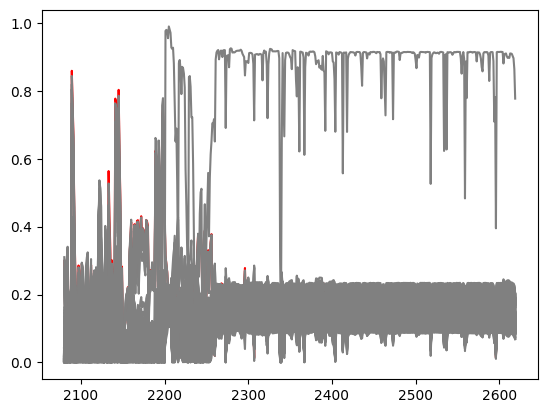

In [24]:
plot_correlations(r,true_value_index, total, start, save=save_figures, fig_name="r_abs.svg", fig_folder=correlations_save_folder)

#### Sign bit recovery

In [25]:
correlations_sign_bit = recover_byte(r, 0, total)

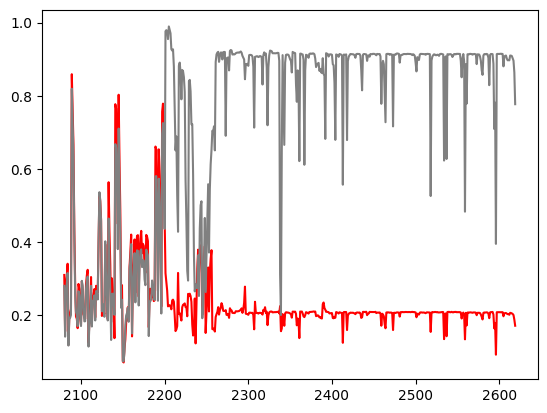

In [26]:
plot_correlations(correlations_sign_bit, true_sign_bit, total, start, save=save_figures, fig_name="sign_bit.svg", fig_folder=correlations_save_folder)

#### Exponent bits Recovery

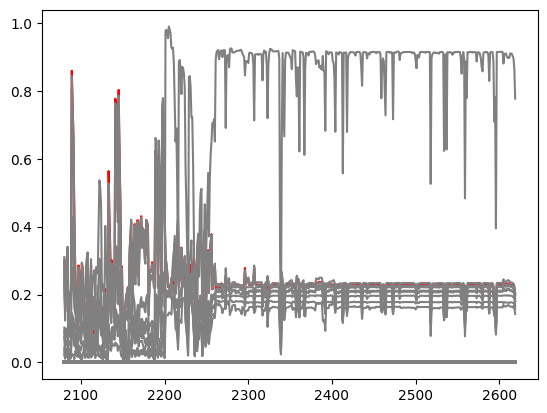

In [27]:
correlations_exponent_bits = recover_byte(r,1, total)
plot_correlations(correlations_exponent_bits, true_exponent_bits, total, start, save=save_figures, fig_name="exponent_bits.svg", fig_folder=correlations_save_folder)

#### First byte of mantissa

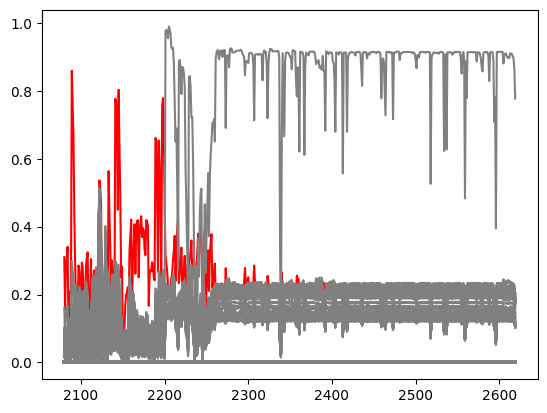

In [28]:
correlations_byte_two = recover_byte(r, 2, total)
plot_correlations(correlations_byte_two, true_byte_two, total, start, save=save_figures, fig_name="byte_two.svg", fig_folder=correlations_save_folder)

#### Second byte of mantissa

In [29]:
correlations_byte_three = recover_byte(r, 3, total)

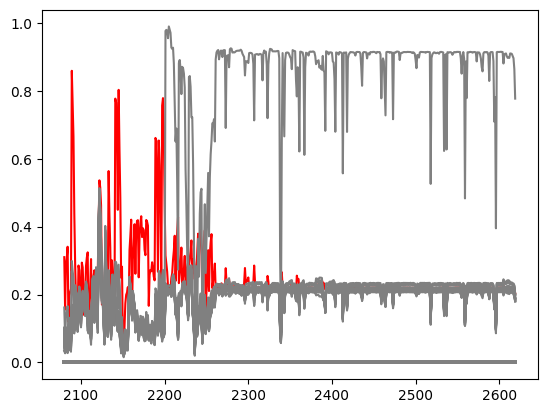

In [30]:
plot_correlations(correlations_byte_three, true_byte_three, total, start, save=save_figures, fig_name="byte_three.svg", fig_folder=correlations_save_folder)

#### Last 7 bits recovery

In [31]:
correlations_byte_four = recover_byte(r, 4, total)

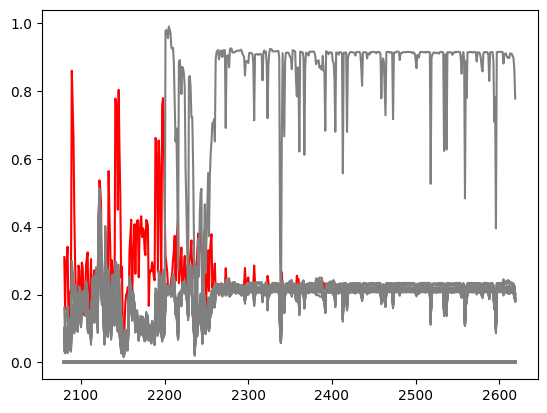

In [32]:
plot_correlations(correlations_byte_four, true_byte_four, total, start , save=save_figures, fig_name="byte_four.svg", fig_folder=correlations_save_folder)

In [33]:
savefile(correlations_save_folder , "signbit", correlations_sign_bit, total, start)
savefile(correlations_save_folder , "exponentbits", correlations_exponent_bits, total, start)
savefile(correlations_save_folder , "firstbyte", correlations_byte_two, total, start)
savefile(correlations_save_folder , "secondbyte", correlations_byte_three, total, start)
savefile(correlations_save_folder , "lastbits", correlations_byte_four, total, start)

In [34]:
max_overall, max_true_overall = find_max_and_max_true(r, true_weight_index)
max_sign_bit, max_true_sign_bit = find_max_and_max_true(correlations_sign_bit, true_sign_bit)
max_exponent_bits, max_true_exponent_bits = find_max_and_max_true(correlations_exponent_bits, true_exponent_bits)
max_byte_two, max_true_byte_two = find_max_and_max_true(correlations_byte_two, true_byte_two)
max_byte_three, max_true_byte_three = find_max_and_max_true(correlations_byte_three, true_byte_three)
max_byte_four, max_true_byte_four = find_max_and_max_true(correlations_byte_four, true_byte_four)

In [35]:
print(max_overall, max_true_overall)
print(max_sign_bit, max_true_sign_bit)
print(max_exponent_bits, max_true_exponent_bits)
print(max_byte_two, max_true_byte_two)
print(max_byte_three, max_true_byte_three)
print(max_byte_four, max_true_byte_four)

0.989602416097567 0.8590986607545535
0.989602416097567 0.8590986607545535
0.989602416097567 0.8590986607545535
0.989602416097567 0.8590986607545535
0.989602416097567 0.8590986607545535
0.989602416097567 0.8590986607545535


In [36]:
find_max_first_byte(total, start, correlations_save_folder, "firstbyte_max", correlations_byte_two)

# Attack on unprotected traces - the whole neuron

In [37]:
start_all = 490
end_all = 4301
total_all = end_all - start_all

save_figures_all = True

In [38]:
r_all = CPA_attack(num_of_traces=10000, inputs_arr=inputs, total_time_sample=total_all, start_time_sample=start_all, trace_arr=traces)

num_of_traces=10000 (490-4301) time samples - calculating for time sample 490
num_of_traces=10000 (490-4301) time samples - calculating for time sample 590
num_of_traces=10000 (490-4301) time samples - calculating for time sample 690
num_of_traces=10000 (490-4301) time samples - calculating for time sample 790
num_of_traces=10000 (490-4301) time samples - calculating for time sample 890
num_of_traces=10000 (490-4301) time samples - calculating for time sample 990
num_of_traces=10000 (490-4301) time samples - calculating for time sample 1090
num_of_traces=10000 (490-4301) time samples - calculating for time sample 1190
num_of_traces=10000 (490-4301) time samples - calculating for time sample 1290
num_of_traces=10000 (490-4301) time samples - calculating for time sample 1390
num_of_traces=10000 (490-4301) time samples - calculating for time sample 1490
num_of_traces=10000 (490-4301) time samples - calculating for time sample 1590
num_of_traces=10000 (490-4301) time samples - calculating 

In [39]:
correlations_save_folder_all = "new_experiments_results/fourth_weight_unprotected_whole_neuron/"

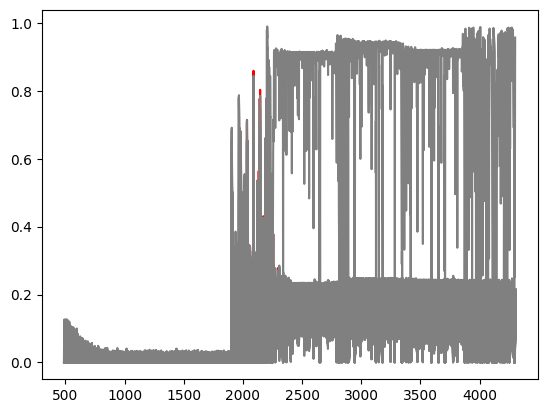

In [40]:
plot_correlations(r_all,true_value_index, total_all, start_all, save=save_figures, fig_name="r_abs.svg", fig_folder=correlations_save_folder)

#### sign bit recovery

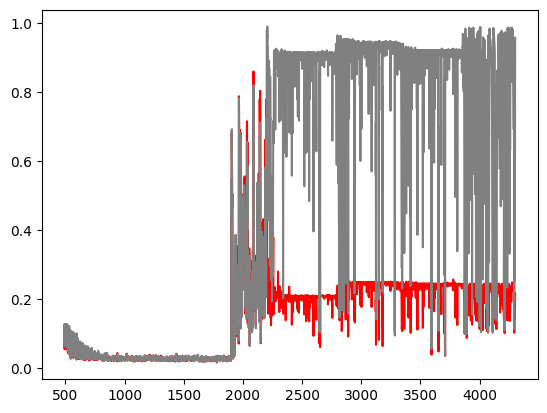

In [41]:
correlations_sign_bit_all = recover_byte(r_all, 0, total_all)
plot_correlations(correlations_sign_bit_all, true_sign_bit, total_all, start_all, save=save_figures_all, fig_name="sign_bit.svg", fig_folder=correlations_save_folder_all)

#### Exponent bits recovery

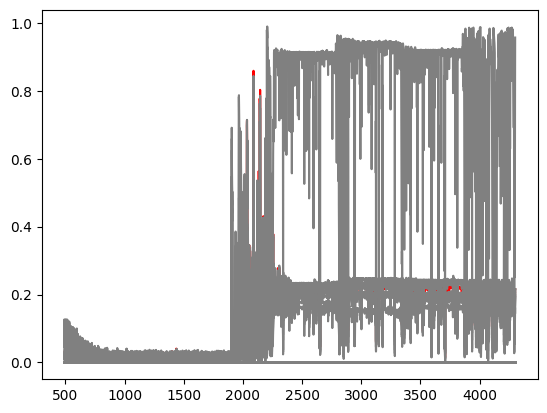

In [42]:
correlations_exponent_bits_all = recover_byte(r_all,1, total_all)
plot_correlations(correlations_exponent_bits_all, true_exponent_bits, total_all, start_all, save=save_figures_all, fig_name="exponent_bits.svg", fig_folder=correlations_save_folder_all)

#### First byte of mantissa

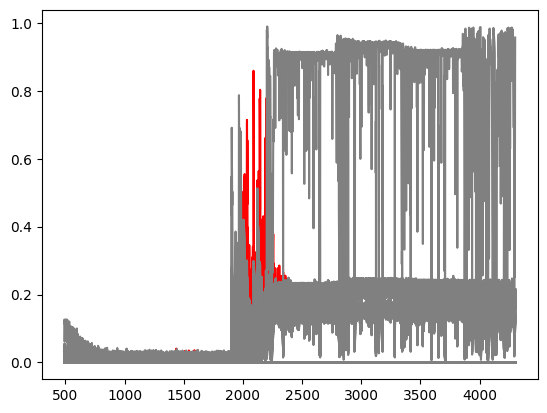

In [43]:
correlations_byte_two_all = recover_byte(r_all, 2, total_all)
plot_correlations(correlations_byte_two_all, true_byte_two, total_all, start_all, save=save_figures_all, fig_name="byte_two.svg", fig_folder=correlations_save_folder_all)

#### Second byte of mantissa

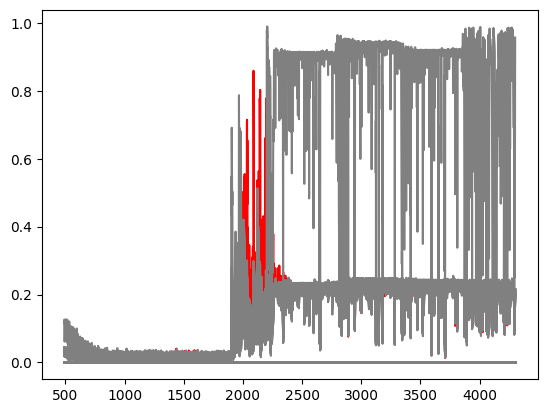

In [44]:
correlations_byte_three_all = recover_byte(r_all, 3, total_all)
plot_correlations(correlations_byte_three_all, true_byte_three, total_all, start_all, save=save_figures_all, fig_name="byte_three.svg", fig_folder=correlations_save_folder_all)

#### Last 7 bits 

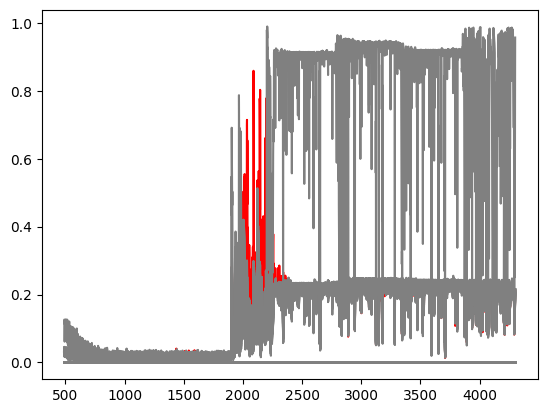

In [45]:
correlations_byte_four_all = recover_byte(r_all, 4, total_all)
plot_correlations(correlations_byte_four_all, true_byte_four, total_all, start_all , save=save_figures_all, fig_name="byte_four.svg", fig_folder=correlations_save_folder_all)

In [46]:
savefile(correlations_save_folder_all , "signbit", correlations_sign_bit_all, total_all, start_all)
savefile(correlations_save_folder_all , "exponentbits", correlations_exponent_bits_all, total_all, start_all)
savefile(correlations_save_folder_all , "firstbyte", correlations_byte_two_all, total_all, start_all)
savefile(correlations_save_folder_all , "secondbyte", correlations_byte_three_all, total_all, start_all)
savefile(correlations_save_folder_all , "lastbits", correlations_byte_four_all, total_all, start_all)

In [47]:
max_overall_all, max_true_overall_all = find_max_and_max_true(r_all, true_weight_index)
max_sign_bit_all, max_true_sign_bit_all = find_max_and_max_true(correlations_sign_bit_all, true_sign_bit)
max_exponent_bits_all, max_true_exponent_bits_all = find_max_and_max_true(correlations_exponent_bits_all, true_exponent_bits)
max_byte_two_all, max_true_byte_two_all = find_max_and_max_true(correlations_byte_two_all, true_byte_two)
max_byte_three_all, max_true_byte_three_all = find_max_and_max_true(correlations_byte_three_all, true_byte_three)
max_byte_four_all, max_true_byte_four_all = find_max_and_max_true(correlations_byte_four_all, true_byte_four)

In [48]:
print(max_overall_all, max_true_overall_all)
print(max_sign_bit_all, max_true_sign_bit_all)
print(max_exponent_bits_all, max_true_exponent_bits_all)
print(max_byte_two_all, max_true_byte_two_all)
print(max_byte_three_all, max_true_byte_three_all)
print(max_byte_four_all, max_true_byte_four_all)

0.989602416097567 0.8590986607545535
0.989602416097567 0.8590986607545535
0.989602416097567 0.8590986607545535
0.989602416097567 0.8590986607545535
0.989602416097567 0.8590986607545535
0.989602416097567 0.8590986607545535


In [49]:
find_max_first_byte(total_all, start_all, correlations_save_folder_all, "firstbyte_max", correlations_byte_two_all)

# Attack on protected traces

In [50]:
#traces_pro, inputs_pro = load_traces(num_of_traces=10000, folder_name="protected")
project_name_pro = "fourth_weight_protected"
traces_pro, inputs_pro = load_traces_cw_project(project_folder="cw_projects/", project_name=project_name_pro)

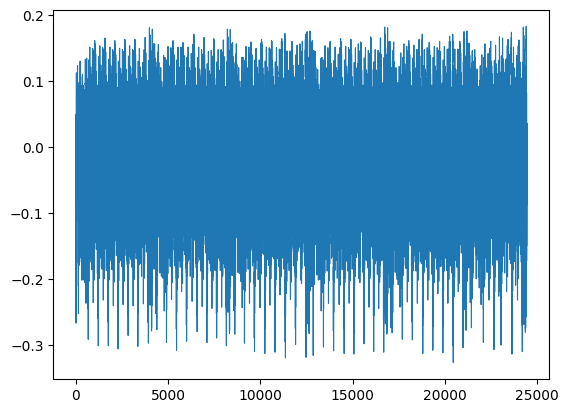

In [51]:
plot_trace(traces_pro[0])

In [52]:
start = 490
end_pro = 4301
total_pro = end_pro - start

In [53]:
# run_CPA_n_traces(inputs_arr=inputs_pro,
#                  total_ts=total_pro,
#                  start_ts=start,
#                  trace_arr=traces_pro,
#                  nlow=10,
#                  nhigh=1000,
#                  nincrement=10,
#                  save_folder="test")

In [54]:
r_pro = CPA_attack(num_of_traces=10000, inputs_arr=inputs_pro, total_time_sample=total_pro, start_time_sample=start, trace_arr=traces_pro)

num_of_traces=10000 (490-4301) time samples - calculating for time sample 490
num_of_traces=10000 (490-4301) time samples - calculating for time sample 590
num_of_traces=10000 (490-4301) time samples - calculating for time sample 690
num_of_traces=10000 (490-4301) time samples - calculating for time sample 790
num_of_traces=10000 (490-4301) time samples - calculating for time sample 890
num_of_traces=10000 (490-4301) time samples - calculating for time sample 990
num_of_traces=10000 (490-4301) time samples - calculating for time sample 1090
num_of_traces=10000 (490-4301) time samples - calculating for time sample 1190
num_of_traces=10000 (490-4301) time samples - calculating for time sample 1290
num_of_traces=10000 (490-4301) time samples - calculating for time sample 1390
num_of_traces=10000 (490-4301) time samples - calculating for time sample 1490
num_of_traces=10000 (490-4301) time samples - calculating for time sample 1590
num_of_traces=10000 (490-4301) time samples - calculating 

In [55]:
correlations_save_folder_pro = "new_experiments_results/fourth_weight_protected/"
save_figures_pro = True

#### Correlations for each weight value

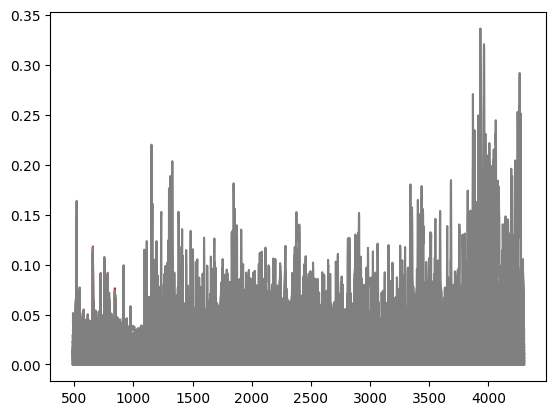

In [56]:
plot_correlations(r_pro,true_value_index, total_pro, start, save=save_figures_pro, fig_name="r_abs.svg", fig_folder=correlations_save_folder_pro)

#### Sign bit recovery

In [57]:
correlations_sign_bit_pro = recover_byte(r_pro, 0, total_pro)

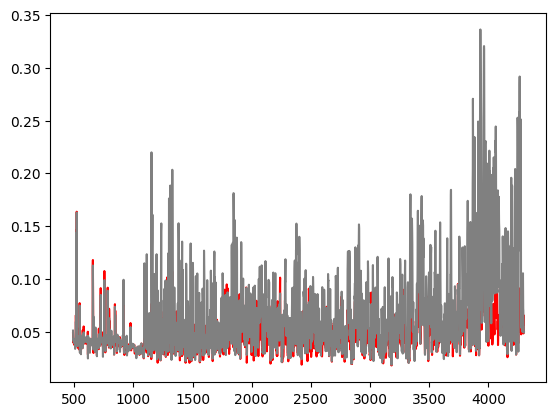

In [58]:
plot_correlations(correlations_sign_bit_pro, true_sign_bit, total_pro, start, save=save_figures_pro, fig_name="sign_bit.svg", fig_folder=correlations_save_folder_pro)

#### Exponent bits ecovery

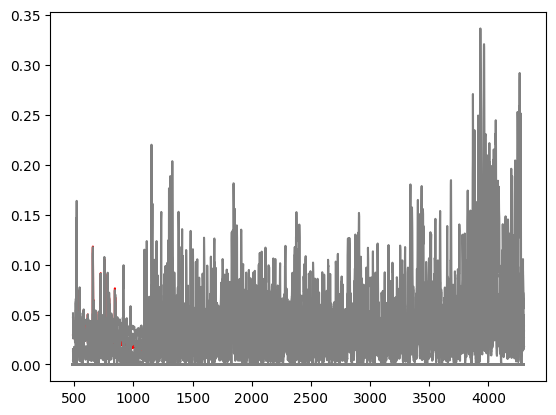

In [59]:
correlations_exponent_bits_pro = recover_byte(r_pro, 1, total_pro)
plot_correlations(correlations_exponent_bits_pro, true_exponent_bits, total_pro, start, save=save_figures_pro, fig_name="exponent_bits.svg", fig_folder=correlations_save_folder_pro)

#### First byte of mantissa

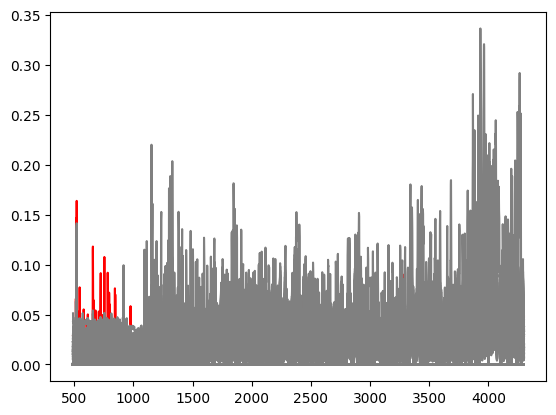

In [60]:
correlations_byte_two_pro = recover_byte(r_pro, 2, total_pro)
plot_correlations(correlations_byte_two_pro, true_byte_two, total_pro, start, save=save_figures_pro, fig_name="first_byte.svg", fig_folder=correlations_save_folder_pro)

#### Second byte of mantissa

In [61]:
correlations_byte_three_pro = recover_byte(r_pro, 3, total_pro)

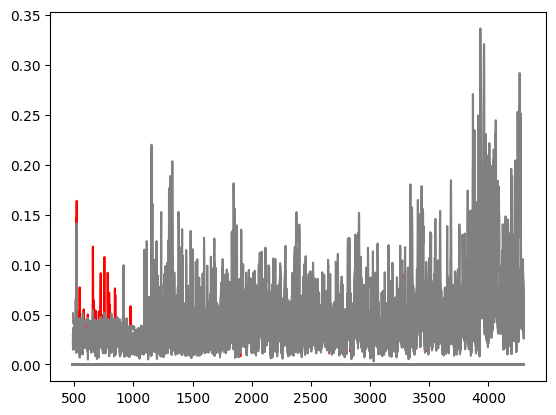

In [62]:
plot_correlations(correlations_byte_three_pro, true_byte_three, total_pro, start, save=save_figures_pro, fig_name="second_byte.svg", fig_folder=correlations_save_folder_pro)

#### Last 7 bits recovery

In [63]:
correlations_byte_four_pro = recover_byte(r_pro, 4, total_pro)

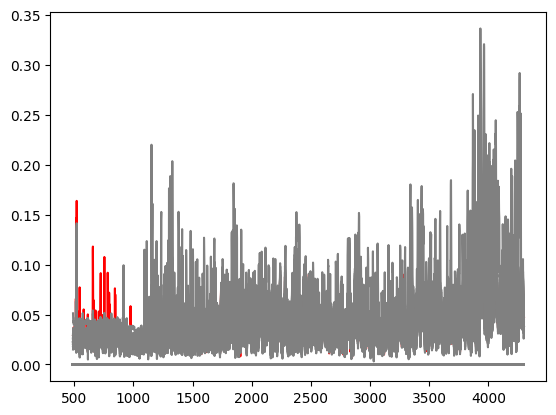

In [64]:
plot_correlations(correlations_byte_four_pro, true_byte_four, total_pro, start, save=save_figures_pro, fig_name="last_bits.svg", fig_folder=correlations_save_folder_pro)

In [65]:
savefile(correlations_save_folder_pro, "shuffled_signbit", correlations_sign_bit_pro, total_pro, start)
savefile(correlations_save_folder_pro, "shuffled_exponentbits", correlations_exponent_bits_pro, total_pro, start)
savefile(correlations_save_folder_pro, "shuffled_firstbyte", correlations_byte_two_pro, total_pro, start)
savefile(correlations_save_folder_pro, "shuffled_secondbyte", correlations_byte_three_pro, total_pro, start)
savefile(correlations_save_folder_pro, "shuffled_lastbits", correlations_byte_four_pro, total_pro, start)

In [66]:
max_overall_pro, max_true_overall_pro = find_max_and_max_true(r_pro, true_weight_index)
max_sign_bit_pro, max_true_sign_bit_pro = find_max_and_max_true(correlations_sign_bit_pro, true_sign_bit)
max_exponent_bits_pro, max_true_exponent_bits_pro = find_max_and_max_true(correlations_exponent_bits_pro, true_exponent_bits)
max_byte_two_pro, max_true_byte_two_pro = find_max_and_max_true(correlations_byte_two_pro, true_byte_two)
max_byte_three_pro, max_true_byte_three_pro = find_max_and_max_true(correlations_byte_three_pro, true_byte_three)
max_byte_four_pro, max_true_byte_four_pro = find_max_and_max_true(correlations_byte_four_pro, true_byte_four)

In [67]:
print(max_overall_pro, max_true_overall_pro)
print(max_sign_bit_pro, max_true_sign_bit_pro)
print(max_exponent_bits_pro, max_true_exponent_bits_pro)
print(max_byte_two_pro, max_true_byte_two_pro)
print(max_byte_three_pro, max_true_byte_three_pro)
print(max_byte_four_pro, max_true_byte_four_pro)

0.3362448929718184 0.11800668384953943
0.3362448929718184 0.16371772193636142
0.3362448929718184 0.11800668384953943
0.3362448929718184 0.16371772193636142
0.3362448929718184 0.16371772193636142
0.3362448929718184 0.16371772193636142


In [68]:
find_max_first_byte(total_pro, start, correlations_save_folder_pro, "shuffled_firstbyte_max", correlations_byte_two_pro)

# Find all the possible values for each part of the binary representation

In [ ]:
def print_bytes_for_all():
    all_bytes_values = [[] for i in range(4)]
    
    for i in range(4):
        for weight_value in weights_arr:
            all_bytes_values[0].append(getbyte(weight_value,1))#exponent bytes
            all_bytes_values[1].append(getbyte(weight_value,2))#first byte of mantissa
            all_bytes_values[2].append(getbyte(weight_value,3))#second byte of mantissa
            all_bytes_values[3].append(getbyte(weight_value,4))#last 7 bits
    
    distinct_values = [[] for i in range(4)]
    value_frequency = [[] for i in range(4)]
    num_of_distinct_values = [0 for i in range(4)]
    for i in range(4):
        values, counts = np.unique(all_bytes_values[i], return_counts=True)
        distinct_values[i] = values
        value_frequency[i] = counts
        num_of_distinct_values[i] = len(distinct_values[i])
    
    bytename = ["exponent bits", "first byte of mantissa", "second byte of mantissa", "last 7 bits"]
    for i in range(4):
        print("\nThere are " + str(num_of_distinct_values[i]) + " distinct " + bytename[i])
        for j in range(num_of_distinct_values[i]):
            print(str(distinct_values[i][j]) + ", ", end="")
        print("\nwith frequencies:")
        print(value_frequency[i])
    return

print_bytes_for_all()